# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=35,
        fold=2,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_13-22-21/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4696 | MulticlassF1Score=0.2074
Batch-30 : CrossEntropyLoss=2.4687 | MulticlassF1Score=0.2346
Batch-45 : CrossEntropyLoss=2.4909 | MulticlassF1Score=0.2439
Batch-60 : CrossEntropyLoss=2.4681 | MulticlassF1Score=0.2610
Batch-75 : CrossEntropyLoss=2.4446 | MulticlassF1Score=0.2813
Batch-90 : CrossEntropyLoss=2.4440 | MulticlassF1Score=0.3025
Batch-105: CrossEntropyLoss=2.3941 | MulticlassF1Score=0.3325
Batch-120: CrossEntropyLoss=2.3835 | MulticlassF1Score=0.3642
Batch-135: CrossEntropyLoss=2.3827 | MulticlassF1Score=0.3893
Batch-150: CrossEntropyLoss=2.3757 | MulticlassF1Score=0.4097
Batch-165: CrossEntropyLoss=2.3610 | MulticlassF1Score=0.4274
Batch-180: CrossEntropyLoss=2.3628 | MulticlassF1Score=0.4413
Batch-195: CrossEntropyLoss=2.3948 | MulticlassF1Score=0.4525
Batch-210: CrossEntropyLoss=2.3948 | MulticlassF1Score=0.4625
Batch-225: CrossEntropyLoss=2.3632 | MulticlassF1Score=0.4711
Batch-226: CrossEntropyLoss=2.3735 | MulticlassF1Score=0.4715

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3534 | MulticlassF1Score=0.5934
Batch-30 : CrossEntropyLoss=2.3643 | MulticlassF1Score=0.6017
Batch-45 : CrossEntropyLoss=2.3625 | MulticlassF1Score=0.5984
Batch-60 : CrossEntropyLoss=2.3641 | MulticlassF1Score=0.5977
Batch-63 : CrossEntropyLoss=2.4092 | MulticlassF1Score=0.5967

Training   : Mean CrossEntropyLoss = 2.4228 | Mean MulticlassF1Score = 0.3435
Validation : Mean CrossEntropyLoss = 2.3729 | Mean MulticlassF1Score = 0.5967

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3597 | MulticlassF1Score=0.6000
Batch-30 : CrossEntropyLoss=2.3771 | MulticlassF1Score=0.5952
Batch-45 : CrossEntropyLoss=2.3543 | MulticlassF1Score=0.6195
Batch-60 : CrossEntropyLoss=2.3522 | MulticlassF1Score=0.6336
Batch-75 : CrossEntropyLoss=2.3422 | MulticlassF1Score=0.6418
Batch-90 : CrossEntropyLoss=2.3463 | MulticlassF1Score=0.6508
Batch-105: CrossEntropyLoss=2.3415 | MulticlassF1Score=0.6612
Batch-120: CrossEntropyLoss=2.3233 | MulticlassF1Score=0.6704
Batch-135: CrossEntropyLoss=2.3092 | MulticlassF1Score=0.6820
Batch-150: CrossEntropyLoss=2.3121 | MulticlassF1Score=0.6924
Batch-165: CrossEntropyLoss=2.3094 | MulticlassF1Score=0.7008
Batch-180: CrossEntropyLoss=2.3147 | MulticlassF1Score=0.7084
Batch-195: CrossEntropyLoss=2.3227 | MulticlassF1Score=0.7147
Batch-210: CrossEntropyLoss=2.3179 | MulticlassF1Score=0.7194
Batch-225: CrossEntropyLoss=2.3135 | MulticlassF1Score=0.7243
Batch-226: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.7246

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3148 | MulticlassF1Score=0.8054
Batch-30 : CrossEntropyLoss=2.3124 | MulticlassF1Score=0.8091
Batch-45 : CrossEntropyLoss=2.3119 | MulticlassF1Score=0.8070
Batch-60 : CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8082
Batch-63 : CrossEntropyLoss=2.3109 | MulticlassF1Score=0.8081

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3347 | Mean MulticlassF1Score = 0.6642
Validation : Mean CrossEntropyLoss = 2.3098 | Mean MulticlassF1Score = 0.8072

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8116
Batch-30 : CrossEntropyLoss=2.3154 | MulticlassF1Score=0.8129
Batch-45 : CrossEntropyLoss=2.3232 | MulticlassF1Score=0.8136
Batch-60 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8116
Batch-75 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8118
Batch-90 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8117
Batch-105: CrossEntropyLoss=2.3115 | MulticlassF1Score=0.8117
Batch-120: CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8114
Batch-135: CrossEntropyLoss=2.3123 | MulticlassF1Score=0.8118
Batch-150: CrossEntropyLoss=2.3087 | MulticlassF1Score=0.8120
Batch-165: CrossEntropyLoss=2.3113 | MulticlassF1Score=0.8119
Batch-180: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8121
Batch-195: CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8119
Batch-210: CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8120
Batch-225: CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8124
Batch-226: CrossEntropyLoss=2.3117 | MulticlassF1Score=0.8124

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3077 | MulticlassF1Score=0.8111
Batch-30 : CrossEntropyLoss=2.3192 | MulticlassF1Score=0.8126
Batch-45 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8128
Batch-60 : CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8129
Batch-63 : CrossEntropyLoss=2.3104 | MulticlassF1Score=0.8129

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3065 | Mean MulticlassF1Score = 0.8118
Validation : Mean CrossEntropyLoss = 2.3059 | Mean MulticlassF1Score = 0.8137

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8177
Batch-30 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8167
Batch-45 : CrossEntropyLoss=2.3066 | MulticlassF1Score=0.8153
Batch-60 : CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8159
Batch-75 : CrossEntropyLoss=2.3089 | MulticlassF1Score=0.8159
Batch-90 : CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8149
Batch-105: CrossEntropyLoss=2.3134 | MulticlassF1Score=0.8149
Batch-120: CrossEntropyLoss=2.3140 | MulticlassF1Score=0.8147
Batch-135: CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8150
Batch-150: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8157
Batch-165: CrossEntropyLoss=2.3139 | MulticlassF1Score=0.8160
Batch-180: CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8163
Batch-195: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8163
Batch-210: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8162
Batch-225: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8160
Batch-226: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8160

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8107
Batch-30 : CrossEntropyLoss=2.3110 | MulticlassF1Score=0.8119
Batch-45 : CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8134
Batch-60 : CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8145
Batch-63 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8144

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3048 | Mean MulticlassF1Score = 0.8159
Validation : Mean CrossEntropyLoss = 2.3052 | Mean MulticlassF1Score = 0.8133

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3137 | MulticlassF1Score=0.8180
Batch-30 : CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8208
Batch-45 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8221
Batch-60 : CrossEntropyLoss=2.3090 | MulticlassF1Score=0.8195
Batch-75 : CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8192
Batch-90 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8199
Batch-105: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8219
Batch-120: CrossEntropyLoss=2.3122 | MulticlassF1Score=0.8224
Batch-135: CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8231
Batch-150: CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8240
Batch-165: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8245
Batch-180: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8247
Batch-195: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8249
Batch-210: CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8257
Batch-225: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8257
Batch-226: CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8256

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8235
Batch-30 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8284
Batch-45 : CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8274
Batch-60 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8270
Batch-63 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8264

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3019 | Mean MulticlassF1Score = 0.8227
Validation : Mean CrossEntropyLoss = 2.3014 | Mean MulticlassF1Score = 0.8268

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8300
Batch-30 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8289
Batch-45 : CrossEntropyLoss=2.3124 | MulticlassF1Score=0.8283
Batch-60 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8307
Batch-75 : CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8308
Batch-90 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8313
Batch-105: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8321
Batch-120: CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8324
Batch-135: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8317
Batch-150: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8316
Batch-165: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8318
Batch-180: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8316
Batch-195: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8317
Batch-210: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8311
Batch-225: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8313
Batch-226: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8313

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8349
Batch-30 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8325
Batch-45 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8289
Batch-60 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8282
Batch-63 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8281

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3000 | Mean MulticlassF1Score = 0.8312
Validation : Mean CrossEntropyLoss = 2.3008 | Mean MulticlassF1Score = 0.8327

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8339
Batch-30 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8371
Batch-45 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8350
Batch-60 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8341
Batch-75 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8339
Batch-90 : CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8335
Batch-105: CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8344
Batch-120: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8338
Batch-135: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8337
Batch-150: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8335
Batch-165: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8332
Batch-180: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8330
Batch-195: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8326
Batch-210: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8331
Batch-225: CrossEntropyLoss=2.3081 | MulticlassF1Score=0.8330
Batch-226: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8330

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8277
Batch-30 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8295
Batch-45 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8310
Batch-60 : CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8296
Batch-63 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8297

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2994 | Mean MulticlassF1Score = 0.8335
Validation : Mean CrossEntropyLoss = 2.3004 | Mean MulticlassF1Score = 0.8291

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8357
Batch-30 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8363
Batch-45 : CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8338
Batch-60 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8332
Batch-75 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8335
Batch-90 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8332
Batch-105: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8338
Batch-120: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8346
Batch-135: CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8347
Batch-150: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8346
Batch-165: CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8341
Batch-180: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8343
Batch-195: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8344
Batch-210: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8346
Batch-225: CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8346
Batch-226: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8346

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8327
Batch-30 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8297
Batch-45 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8286
Batch-60 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8294
Batch-63 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8295

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2989 | Mean MulticlassF1Score = 0.8343
Validation : Mean CrossEntropyLoss = 2.3004 | Mean MulticlassF1Score = 0.8297

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8395
Batch-30 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8371
Batch-45 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8349
Batch-60 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8341
Batch-75 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8349
Batch-90 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8340
Batch-105: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8342
Batch-120: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8343
Batch-135: CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8350
Batch-150: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8354
Batch-165: CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8354
Batch-180: CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8352
Batch-195: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8351
Batch-210: CrossEntropyLoss=2.3074 | MulticlassF1Score=0.8350
Batch-225: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8354
Batch-226: CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8353

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8308
Batch-30 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8308
Batch-45 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8317
Batch-60 : CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8298
Batch-63 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8302

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2986 | Mean MulticlassF1Score = 0.8355
Validation : Mean CrossEntropyLoss = 2.3002 | Mean MulticlassF1Score = 0.8315

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8415
Batch-30 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8421
Batch-45 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8408
Batch-60 : CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8403
Batch-75 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8391
Batch-90 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8390
Batch-105: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8380
Batch-120: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8381
Batch-135: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8377
Batch-150: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8380
Batch-165: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8392
Batch-180: CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8399
Batch-195: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8409
Batch-210: CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8419
Batch-225: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8426
Batch-226: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8426

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8519
Batch-30 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8466
Batch-45 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8462
Batch-60 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8464
Batch-63 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8471

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2964 | Mean MulticlassF1Score = 0.8403
Validation : Mean CrossEntropyLoss = 2.2952 | Mean MulticlassF1Score = 0.8477

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8555
Batch-30 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8545
Batch-45 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8539
Batch-60 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8563
Batch-75 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8598
Batch-90 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8623
Batch-105: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8644
Batch-120: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8661
Batch-135: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8673
Batch-150: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8687
Batch-165: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8697
Batch-180: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8709
Batch-195: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8720
Batch-210: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8728
Batch-225: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8737
Batch-226: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8737

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8765
Batch-30 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8762
Batch-45 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8757
Batch-60 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8750
Batch-63 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8746

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2871 | Mean MulticlassF1Score = 0.8644
Validation : Mean CrossEntropyLoss = 2.2867 | Mean MulticlassF1Score = 0.8751

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8888
Batch-30 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8871
Batch-45 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8860
Batch-60 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8872
Batch-75 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8867
Batch-90 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8867
Batch-105: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8859
Batch-120: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.8854
Batch-135: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8845
Batch-150: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8846
Batch-165: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8845
Batch-180: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8842
Batch-195: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8841
Batch-210: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8837
Batch-225: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8837
Batch-226: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8837

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8734
Batch-30 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8750
Batch-45 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8749
Batch-60 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8758
Batch-63 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8758

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2839 | Mean MulticlassF1Score = 0.8858
Validation : Mean CrossEntropyLoss = 2.2862 | Mean MulticlassF1Score = 0.8751

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8876
Batch-30 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8871
Batch-45 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8863
Batch-60 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8850
Batch-75 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8853
Batch-90 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8845
Batch-105: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8850
Batch-120: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8847
Batch-135: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8846
Batch-150: CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8848
Batch-165: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8850
Batch-180: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8855
Batch-195: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8855
Batch-210: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8854
Batch-225: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8854
Batch-226: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8855

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8819
Batch-30 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8771
Batch-45 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8751
Batch-60 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8752
Batch-63 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8756

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2832 | Mean MulticlassF1Score = 0.8856
Validation : Mean CrossEntropyLoss = 2.2861 | Mean MulticlassF1Score = 0.8781

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8869
Batch-30 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8866
Batch-45 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8881
Batch-60 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8878
Batch-75 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.8884
Batch-90 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8877
Batch-105: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8870
Batch-120: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8871
Batch-135: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8870
Batch-150: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8871
Batch-165: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8874
Batch-180: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8876
Batch-195: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8876
Batch-210: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8881
Batch-225: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8882
Batch-226: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8882

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8785
Batch-30 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8770
Batch-45 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8783
Batch-60 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8800
Batch-63 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8797

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2824 | Mean MulticlassF1Score = 0.8875
Validation : Mean CrossEntropyLoss = 2.2849 | Mean MulticlassF1Score = 0.8779

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8946
Batch-30 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8938
Batch-45 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8939
Batch-60 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8933
Batch-75 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8941
Batch-90 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8938
Batch-105: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8941
Batch-120: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8938
Batch-135: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8932
Batch-150: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8932
Batch-165: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8928
Batch-180: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8926
Batch-195: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8925
Batch-210: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8929
Batch-225: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8927
Batch-226: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8927

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8846
Batch-30 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8817
Batch-45 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8815
Batch-60 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8818
Batch-63 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8813

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2809 | Mean MulticlassF1Score = 0.8938
Validation : Mean CrossEntropyLoss = 2.2844 | Mean MulticlassF1Score = 0.8809

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8951
Batch-30 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8956
Batch-45 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8958
Batch-60 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8952
Batch-75 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8955
Batch-90 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8954
Batch-105: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8955
Batch-120: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8955
Batch-135: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.8956
Batch-150: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8954
Batch-165: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8951
Batch-180: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8950
Batch-195: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8949
Batch-210: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8949
Batch-225: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8945
Batch-226: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8945

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8805
Batch-30 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8813
Batch-45 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8798
Batch-60 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8818
Batch-63 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8824

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2803 | Mean MulticlassF1Score = 0.8955
Validation : Mean CrossEntropyLoss = 2.2840 | Mean MulticlassF1Score = 0.8803

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.8992
Batch-30 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8952
Batch-45 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8946
Batch-60 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8946
Batch-75 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8945
Batch-90 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8943
Batch-105: CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8945
Batch-120: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8947
Batch-135: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8953
Batch-150: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8955
Batch-165: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8957
Batch-180: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8961
Batch-195: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8960
Batch-210: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8960
Batch-225: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8957
Batch-226: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8956

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8787
Batch-30 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8828
Batch-45 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8827
Batch-60 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8820
Batch-63 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8821

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2799 | Mean MulticlassF1Score = 0.8957
Validation : Mean CrossEntropyLoss = 2.2841 | Mean MulticlassF1Score = 0.8813

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8950
Batch-30 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8959
Batch-45 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8962
Batch-60 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8958
Batch-75 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8969
Batch-90 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8973
Batch-105: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8968
Batch-120: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8963
Batch-135: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8968
Batch-150: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8968
Batch-165: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8968
Batch-180: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8965
Batch-195: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8966
Batch-210: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8966
Batch-225: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8967
Batch-226: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8966

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8788
Batch-30 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8832
Batch-45 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8828
Batch-60 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8814
Batch-63 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8819

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2796 | Mean MulticlassF1Score = 0.8967
Validation : Mean CrossEntropyLoss = 2.2841 | Mean MulticlassF1Score = 0.8814

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8933
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8945
Batch-45 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8958
Batch-60 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8957
Batch-75 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9004
Batch-90 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9039
Batch-105: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9058
Batch-120: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9077
Batch-135: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9092
Batch-150: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9102
Batch-165: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9111
Batch-180: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9117
Batch-195: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9125
Batch-210: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9127
Batch-225: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9130
Batch-226: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9131

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9028
Batch-30 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9058
Batch-45 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9052
Batch-60 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9051
Batch-63 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9051

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9046
Validation : Mean CrossEntropyLoss = 2.2769 | Mean MulticlassF1Score = 0.9051

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9170
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9215
Batch-45 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9213
Batch-60 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9215
Batch-75 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9220
Batch-90 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9221
Batch-105: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9227
Batch-120: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9230
Batch-135: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9230
Batch-150: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9228
Batch-165: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9231
Batch-180: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9230
Batch-195: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9229
Batch-210: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9229
Batch-225: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9230
Batch-226: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9231

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9102
Batch-30 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9117
Batch-45 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9096
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9111
Batch-63 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.9107

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9217
Validation : Mean CrossEntropyLoss = 2.2755 | Mean MulticlassF1Score = 0.9104

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9255
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9279
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9280
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9284
Batch-75 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9285
Batch-90 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9285
Batch-105: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9274
Batch-120: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9270
Batch-135: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9270
Batch-150: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9265
Batch-165: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9265
Batch-180: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9265
Batch-195: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9266
Batch-210: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9268
Batch-225: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9267
Batch-226: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9266

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9083
Batch-30 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9097
Batch-45 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9106
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9122
Batch-63 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9118

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9272
Validation : Mean CrossEntropyLoss = 2.2750 | Mean MulticlassF1Score = 0.9097

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9262
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9249
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9269
Batch-60 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9265
Batch-75 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9262
Batch-90 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9271
Batch-105: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9269
Batch-120: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9267
Batch-135: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9268
Batch-150: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9271
Batch-165: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9278
Batch-180: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9277
Batch-195: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9277
Batch-210: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9278
Batch-225: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9274
Batch-226: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9273

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9153
Batch-30 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9128
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9124
Batch-60 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9123
Batch-63 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9121

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9270
Validation : Mean CrossEntropyLoss = 2.2749 | Mean MulticlassF1Score = 0.9146

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9266
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9282
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9281
Batch-60 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9284
Batch-75 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9285
Batch-90 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9279
Batch-105: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9279
Batch-120: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9284
Batch-135: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9284
Batch-150: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9281
Batch-165: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9281
Batch-180: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9282
Batch-195: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9283
Batch-210: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9281
Batch-225: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9281
Batch-226: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9281

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9120
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9105
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9107
Batch-60 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9113
Batch-63 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9112

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9282
Validation : Mean CrossEntropyLoss = 2.2750 | Mean MulticlassF1Score = 0.9112

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9310
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9309
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9306
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9299
Batch-75 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9304
Batch-90 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9296
Batch-105: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9292
Batch-120: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9296
Batch-135: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9292
Batch-150: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9292
Batch-165: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9291
Batch-180: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9288
Batch-195: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9290
Batch-210: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9288
Batch-225: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9290
Batch-226: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9290

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9136
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9131
Batch-45 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9125
Batch-60 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9117
Batch-63 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9116

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2695 | Mean MulticlassF1Score = 0.9298
Validation : Mean CrossEntropyLoss = 2.2749 | Mean MulticlassF1Score = 0.9130

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9322
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9310
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9303
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9296
Batch-75 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9306
Batch-90 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9304
Batch-105: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9304
Batch-120: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9298
Batch-135: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9296
Batch-150: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9299
Batch-165: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9298
Batch-180: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9298
Batch-195: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9299
Batch-210: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9298
Batch-225: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9297
Batch-226: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9298

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9138
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9147
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9142
Batch-60 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9126
Batch-63 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9125

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2692 | Mean MulticlassF1Score = 0.9303
Validation : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9136

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9402
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9446
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9455
Batch-60 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9467
Batch-75 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9470
Batch-90 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9471
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9477
Batch-120: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9477
Batch-135: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9480
Batch-150: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9483
Batch-165: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9485
Batch-180: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9484
Batch-195: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9486
Batch-210: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9485
Batch-225: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9483
Batch-226: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9484

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9304
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9315
Batch-45 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9300
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9310
Batch-63 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9310

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9464
Validation : Mean CrossEntropyLoss = 2.2689 | Mean MulticlassF1Score = 0.9305

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9519
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9500
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9506
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9506
Batch-75 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9502
Batch-90 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9496
Batch-105: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9495
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9498
Batch-135: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9495
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9499
Batch-165: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9501
Batch-180: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9504
Batch-195: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9501
Batch-210: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9502
Batch-225: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9500
Batch-226: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9500

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9331
Batch-30 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9322
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9305
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9304
Batch-63 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9308

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9502
Validation : Mean CrossEntropyLoss = 2.2689 | Mean MulticlassF1Score = 0.9311

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9504
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9501
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9499
Batch-60 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9500
Batch-75 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9502
Batch-90 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9503
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9502
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9504
Batch-135: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9501
Batch-150: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9506
Batch-165: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9503
Batch-180: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9503
Batch-195: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9501
Batch-210: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9503
Batch-225: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9502
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9502

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9330
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9331
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9322
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9314
Batch-63 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9313

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2629 | Mean MulticlassF1Score = 0.9500
Validation : Mean CrossEntropyLoss = 2.2689 | Mean MulticlassF1Score = 0.9326

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9502
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9518
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9511
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9504
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9506
Batch-90 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9506
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9505
Batch-120: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9509
Batch-135: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9508
Batch-150: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9509
Batch-165: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9513
Batch-180: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9512
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9514
Batch-210: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9514
Batch-225: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9512
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9512

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9351
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9337
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9340
Batch-60 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9327
Batch-63 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9322

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2626 | Mean MulticlassF1Score = 0.9510
Validation : Mean CrossEntropyLoss = 2.2686 | Mean MulticlassF1Score = 0.9340

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9549
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9560
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9559
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9538
Batch-75 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9535
Batch-90 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9534
Batch-105: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9532
Batch-120: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9532
Batch-135: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9530
Batch-150: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9527
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9528
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9528
Batch-195: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9528
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9525
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9523
Batch-226: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9523

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9314
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9338
Batch-45 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9332
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9328
Batch-63 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9328

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2623 | Mean MulticlassF1Score = 0.9535
Validation : Mean CrossEntropyLoss = 2.2684 | Mean MulticlassF1Score = 0.9334

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9508
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9543
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9520
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9521
Batch-75 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9523
Batch-90 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9520
Batch-105: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9523
Batch-120: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9525
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9526
Batch-150: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9528
Batch-165: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9526
Batch-180: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9528
Batch-195: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9529
Batch-210: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9531
Batch-225: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9530
Batch-226: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9530

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9347
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9348
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9334
Batch-60 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9330
Batch-63 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9327

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2620 | Mean MulticlassF1Score = 0.9524
Validation : Mean CrossEntropyLoss = 2.2684 | Mean MulticlassF1Score = 0.9325

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9510
Batch-30 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9534
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9538
Batch-60 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9536
Batch-75 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9537
Batch-90 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9535
Batch-105: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9532
Batch-120: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9537
Batch-135: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9542
Batch-150: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9541
Batch-165: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9541
Batch-180: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9541
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9539
Batch-210: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9535
Batch-225: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9533
Batch-226: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9533

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9319
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9326
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9334
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9330
Batch-63 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9329

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2620 | Mean MulticlassF1Score = 0.9536
Validation : Mean CrossEntropyLoss = 2.2682 | Mean MulticlassF1Score = 0.9328

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9542
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9532
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9539
Batch-60 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9534
Batch-75 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9536
Batch-90 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9542
Batch-105: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9541
Batch-120: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9542
Batch-135: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9538
Batch-150: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9538
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9539
Batch-180: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9537
Batch-195: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9537
Batch-210: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9538
Batch-225: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9537
Batch-226: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9536

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9309
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9318
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9328
Batch-60 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9330
Batch-63 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9331

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2618 | Mean MulticlassF1Score = 0.9539
Validation : Mean CrossEntropyLoss = 2.2682 | Mean MulticlassF1Score = 0.9325

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9558
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9555
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9555
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9550
Batch-75 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9542
Batch-90 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9547
Batch-105: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9547
Batch-120: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9551
Batch-135: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9548
Batch-150: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9547
Batch-165: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9545
Batch-180: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9545
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9543
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9544
Batch-225: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9543
Batch-226: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9544

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9304
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9343
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9347
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9362
Batch-63 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9359

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2616 | Mean MulticlassF1Score = 0.9548
Validation : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9338

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9570
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9572
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9579
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9574
Batch-75 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9570
Batch-90 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9575
Batch-105: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9571
Batch-120: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9571
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9578
Batch-150: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9579
Batch-165: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9580
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9578
Batch-195: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9578
Batch-210: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9579
Batch-225: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9577
Batch-226: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9577

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9308
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9359
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9365
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9375
Batch-63 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9377

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2606 | Mean MulticlassF1Score = 0.9576
Validation : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9351

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9597
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9590
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9582
Batch-60 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9586
Batch-75 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9588
Batch-90 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9591
Batch-105: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9591
Batch-120: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9591
Batch-135: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9587
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9591
Batch-165: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9593
Batch-180: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9594
Batch-195: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9591
Batch-210: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9589
Batch-225: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9590
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9590

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9404
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9408
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9406
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9393
Batch-63 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9390

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2601 | Mean MulticlassF1Score = 0.9591
Validation : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9405

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9610
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9594
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9605
Batch-60 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9603
Batch-75 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9598
Batch-90 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9603
Batch-105: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9602
Batch-120: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9596
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9597
Batch-150: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9593
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9597
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9596
Batch-195: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9598
Batch-210: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9598
Batch-225: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9598
Batch-226: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9598

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9421
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9406
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9401
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9391
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9389

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2599 | Mean MulticlassF1Score = 0.9601
Validation : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9397

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9610
Batch-30 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9603
Batch-45 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9613
Batch-60 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9633
Batch-75 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9637
Batch-90 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9643
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9650
Batch-120: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9654
Batch-135: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9657
Batch-150: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9658
Batch-165: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9660
Batch-180: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9662
Batch-195: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9663
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9666
Batch-225: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9666
Batch-226: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9666

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9473

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9643
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9471

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9680
Batch-30 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9698
Batch-60 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9695
Batch-75 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9698
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9700
Batch-105: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9697
Batch-120: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9697
Batch-135: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9692
Batch-150: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9691
Batch-165: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9688
Batch-180: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9688
Batch-195: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9687
Batch-210: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9687
Batch-225: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9687
Batch-226: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9687

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9483
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9470
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9474

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9695
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9472

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9712
Batch-30 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9695
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9698
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9700
Batch-90 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9704
Batch-105: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9700
Batch-120: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9697
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9694
Batch-150: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9693
Batch-165: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9692
Batch-210: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9692
Batch-225: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9691
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9691

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9436
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9462
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9475
Batch-63 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9477

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9694
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9452

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9716
Batch-30 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9711
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9703
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9700
Batch-75 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9706
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9706
Batch-105: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9703
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9700
Batch-135: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9698
Batch-150: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9699
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9698
Batch-180: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9696
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9696
Batch-210: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9695
Batch-225: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9694
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9694

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9448
Batch-30 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9467
Batch-63 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9472

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9702
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9460

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9695
Batch-30 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9689
Batch-45 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9697
Batch-60 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9695
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9701
Batch-90 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9699
Batch-105: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9700
Batch-120: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9696
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9699
Batch-150: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9697
Batch-165: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9698
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9695
Batch-195: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9695
Batch-210: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9696
Batch-225: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9695
Batch-226: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9695

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9453
Batch-30 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9468
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9477

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9695
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9467

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9703
Batch-30 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9706
Batch-45 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9703
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9705
Batch-75 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9706
Batch-90 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9700
Batch-105: CrossEntropyLoss=2.2522 | MulticlassF1Score=0.9702
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9704
Batch-135: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9707
Batch-150: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9707
Batch-165: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9706
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9703
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9702
Batch-210: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9701
Batch-225: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9701
Batch-226: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9701

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9470

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9705
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9466

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9714
Batch-30 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9718
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9703
Batch-60 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9710
Batch-75 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9709
Batch-90 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9707
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9702
Batch-120: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9702
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9699
Batch-150: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9697
Batch-165: CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9697
Batch-180: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9696
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9697
Batch-210: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9695
Batch-225: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9694
Batch-226: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9695

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9452
Batch-30 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9474
Batch-63 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9474

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9703
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9464
Patience = 1/50‚ùó

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9713
Batch-30 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9700
Batch-45 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9696
Batch-60 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9698
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9699
Batch-90 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9699
Batch-105: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9701
Batch-120: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9704
Batch-135: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9704
Batch-150: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9701
Batch-165: CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9700
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9701
Batch-195: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9702
Batch-210: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9702
Batch-225: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9702
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9702

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9476
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9496
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9482

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9702
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9488

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9728
Batch-30 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9711
Batch-45 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9706
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9705
Batch-75 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9701
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9701
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9705
Batch-120: CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9707
Batch-135: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9710
Batch-150: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9709
Batch-165: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9708
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9708
Batch-195: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9707
Batch-210: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9706
Batch-225: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9707
Batch-226: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9707

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9458
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9493
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9490

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2565 | Mean MulticlassF1Score = 0.9708
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9466

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9710
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9708
Batch-45 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9708
Batch-60 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9708
Batch-75 : CrossEntropyLoss=2.2519 | MulticlassF1Score=0.9708
Batch-90 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9707
Batch-105: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9708
Batch-120: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9709
Batch-135: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9706
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9708
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9708
Batch-180: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9710
Batch-195: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9710
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9710
Batch-225: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9710
Batch-226: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9710

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9505
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9496
Batch-45 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9479
Batch-63 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9479

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9710
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9482

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9732
Batch-30 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9717
Batch-45 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9723
Batch-60 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9714
Batch-75 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9708
Batch-90 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9711
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9713
Batch-120: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9710
Batch-135: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9707
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9709
Batch-165: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9710
Batch-180: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9709
Batch-195: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9713
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9713
Batch-225: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9713
Batch-226: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9712

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9484
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9486
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9485

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9715
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9489

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9734
Batch-30 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9718
Batch-45 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9704
Batch-60 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9700
Batch-75 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9695
Batch-90 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9696
Batch-105: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9696
Batch-120: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9697
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9697
Batch-150: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9699
Batch-165: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9700
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9699
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9699
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9699
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9699
Batch-226: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9699

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9486
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9486
Batch-45 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9490
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9481

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9704
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9488
Patience = 2/50‚ùó

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9732
Batch-30 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9719
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9715
Batch-60 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9713
Batch-75 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9710
Batch-90 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9714
Batch-105: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9712
Batch-120: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9708
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9710
Batch-150: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9711
Batch-165: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9710
Batch-180: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9710
Batch-195: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9711
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9710
Batch-225: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9709
Batch-226: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9708

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9493
Batch-63 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9491

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2565 | Mean MulticlassF1Score = 0.9714
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9481

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2565
Best CrossEntropyLoss training    : 2.2633
Best MulticlassF1Score validation : 0.9714
Best MulticlassF1Score validation : 0.9481
Training duration                 : 4.5981 minutes.
Training date                     : 2022-10-19 09:52:54.767086+08:00


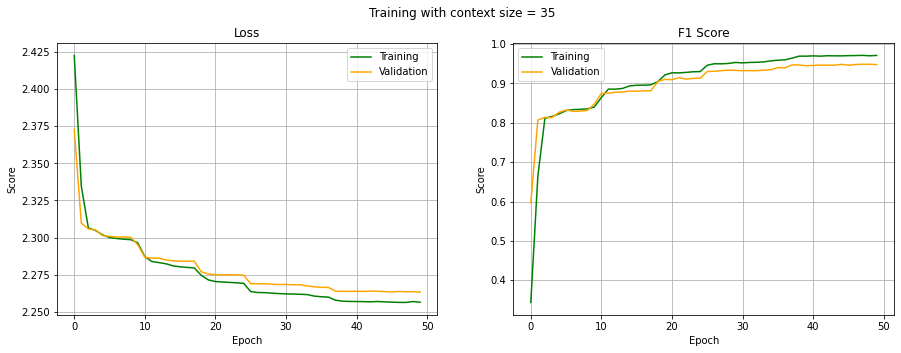

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah üéâüòÑ! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah üéâüòÑ! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft üò•! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}‚ùó")
                    
                    f.write("\nHuft üò•! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}‚ùó\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah üéâüòÑ! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah üéâüòÑ! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft üò•! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}‚ùó\n")
                    
                    f.write("\nHuft üò•! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}‚ùó\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}‚ùó\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}‚ùó\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9717, device='cuda:0'),
 tensor(0.9491, device='cuda:0'),
 tensor(0.9473, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9717, device='cuda:0'),
 tensor(0.9491, device='cuda:0'),
 tensor(0.9473, device='cuda:0'))

## Heatmap

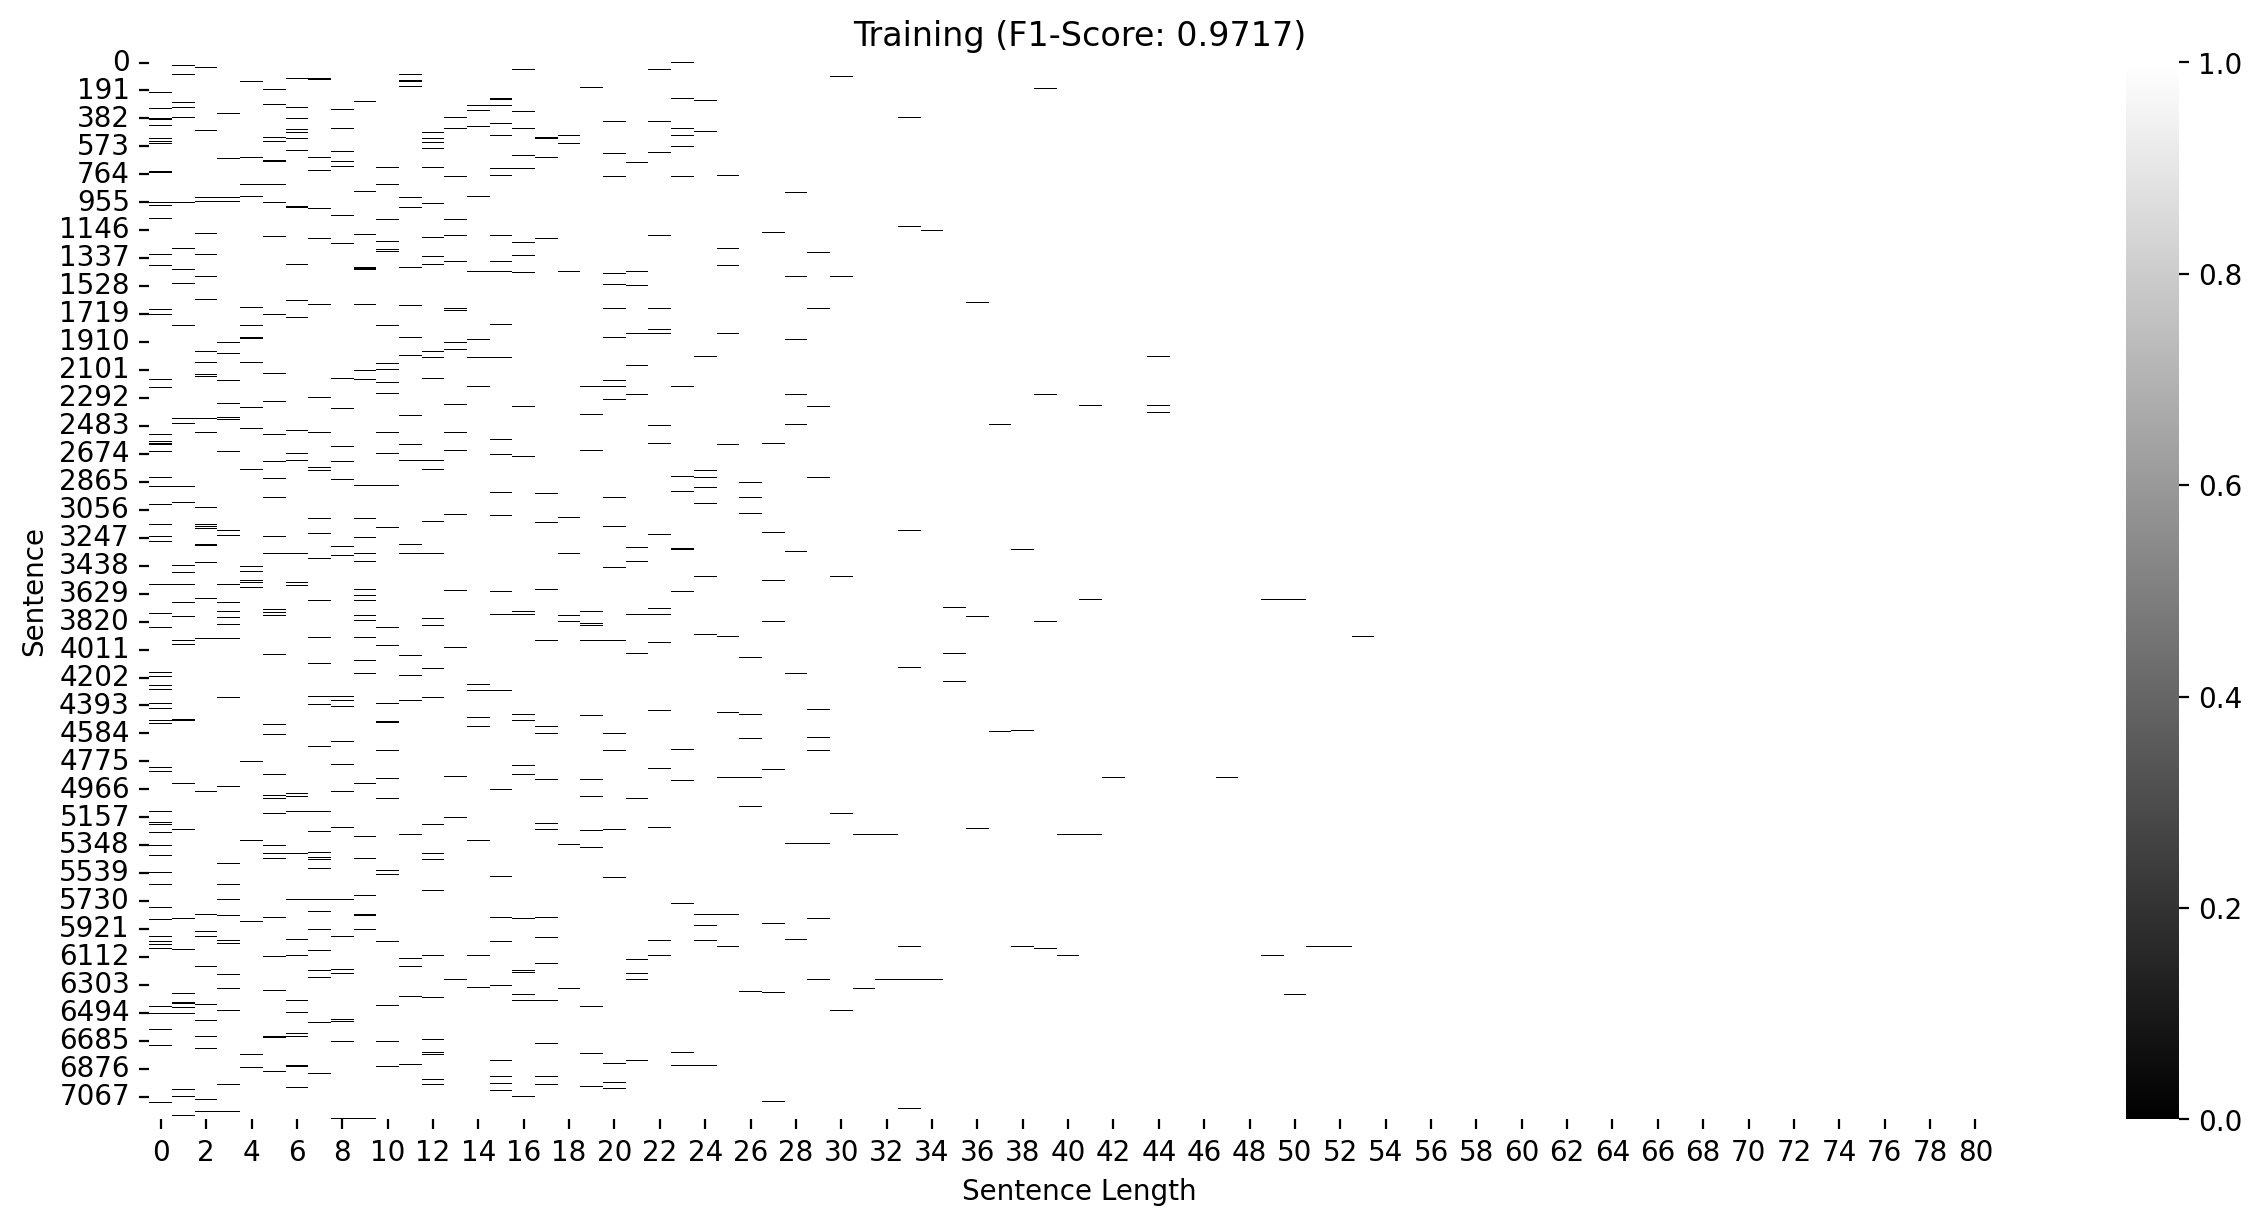

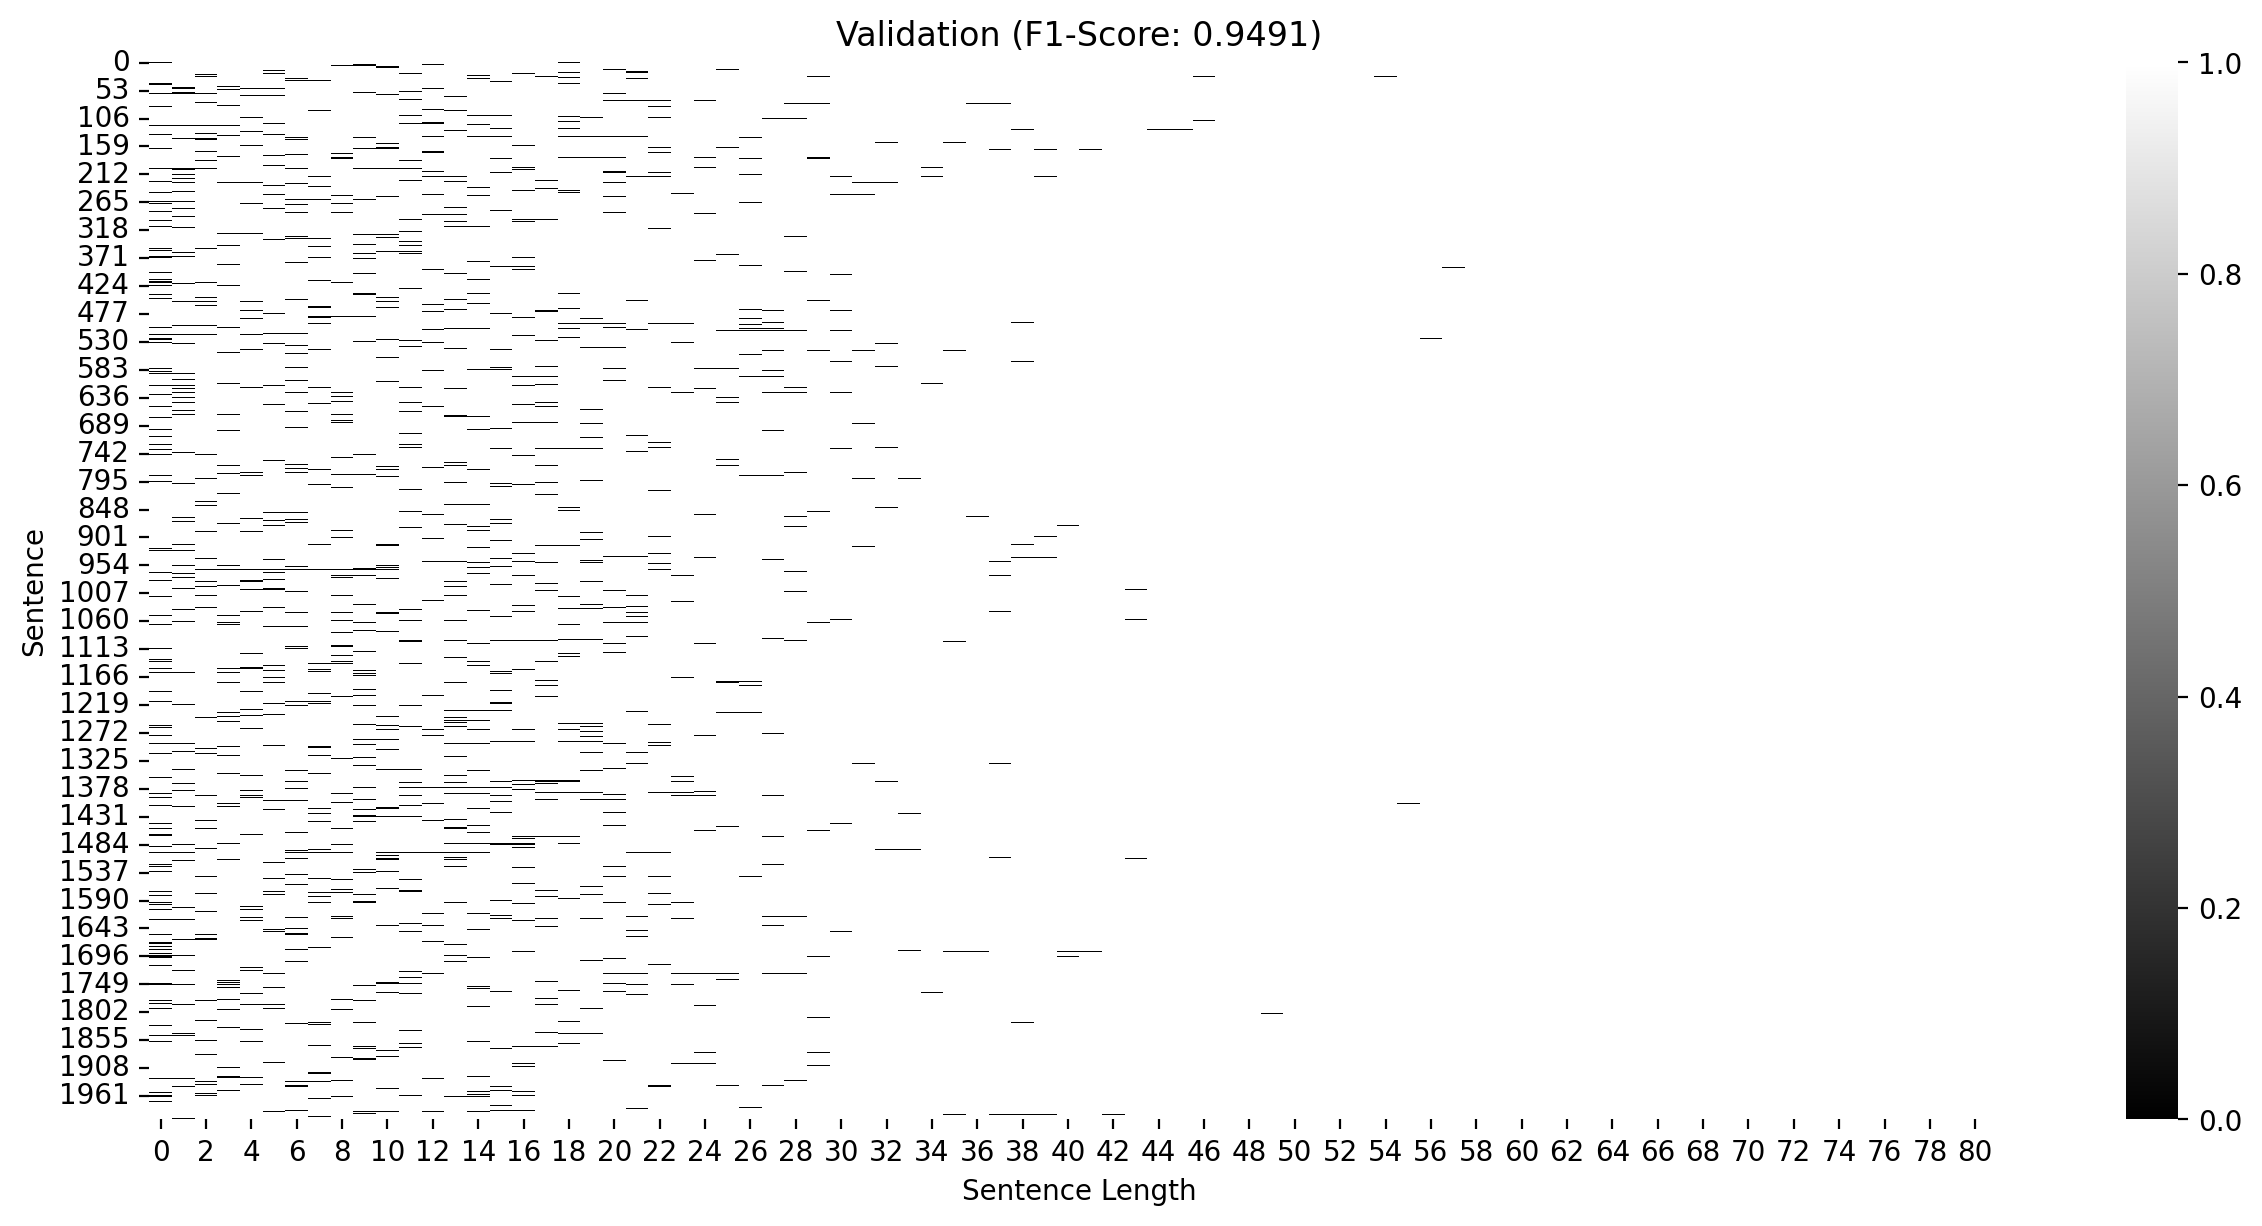

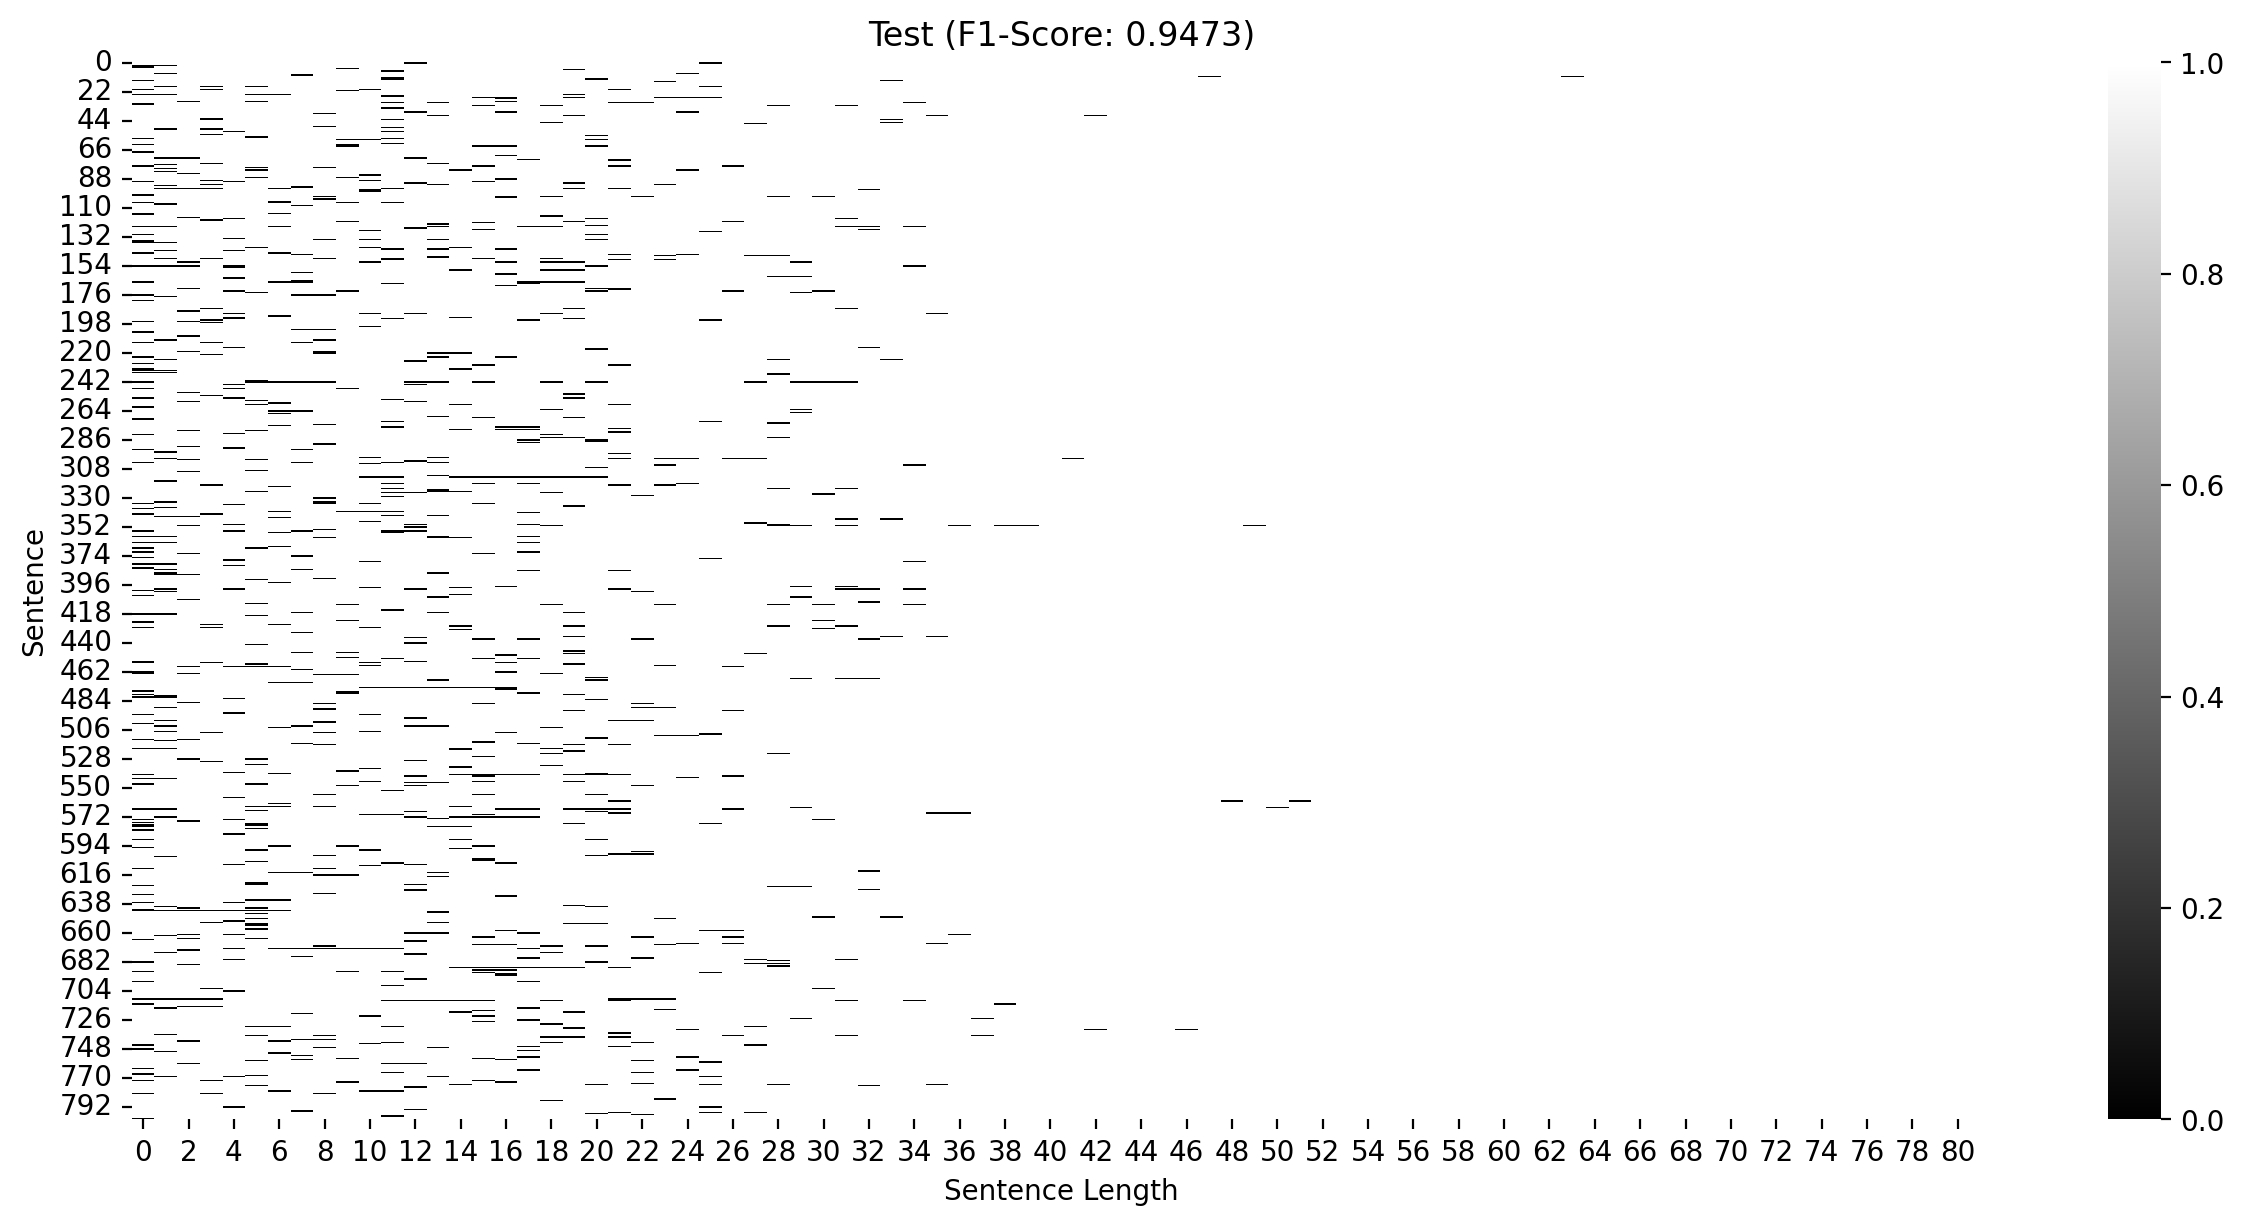

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


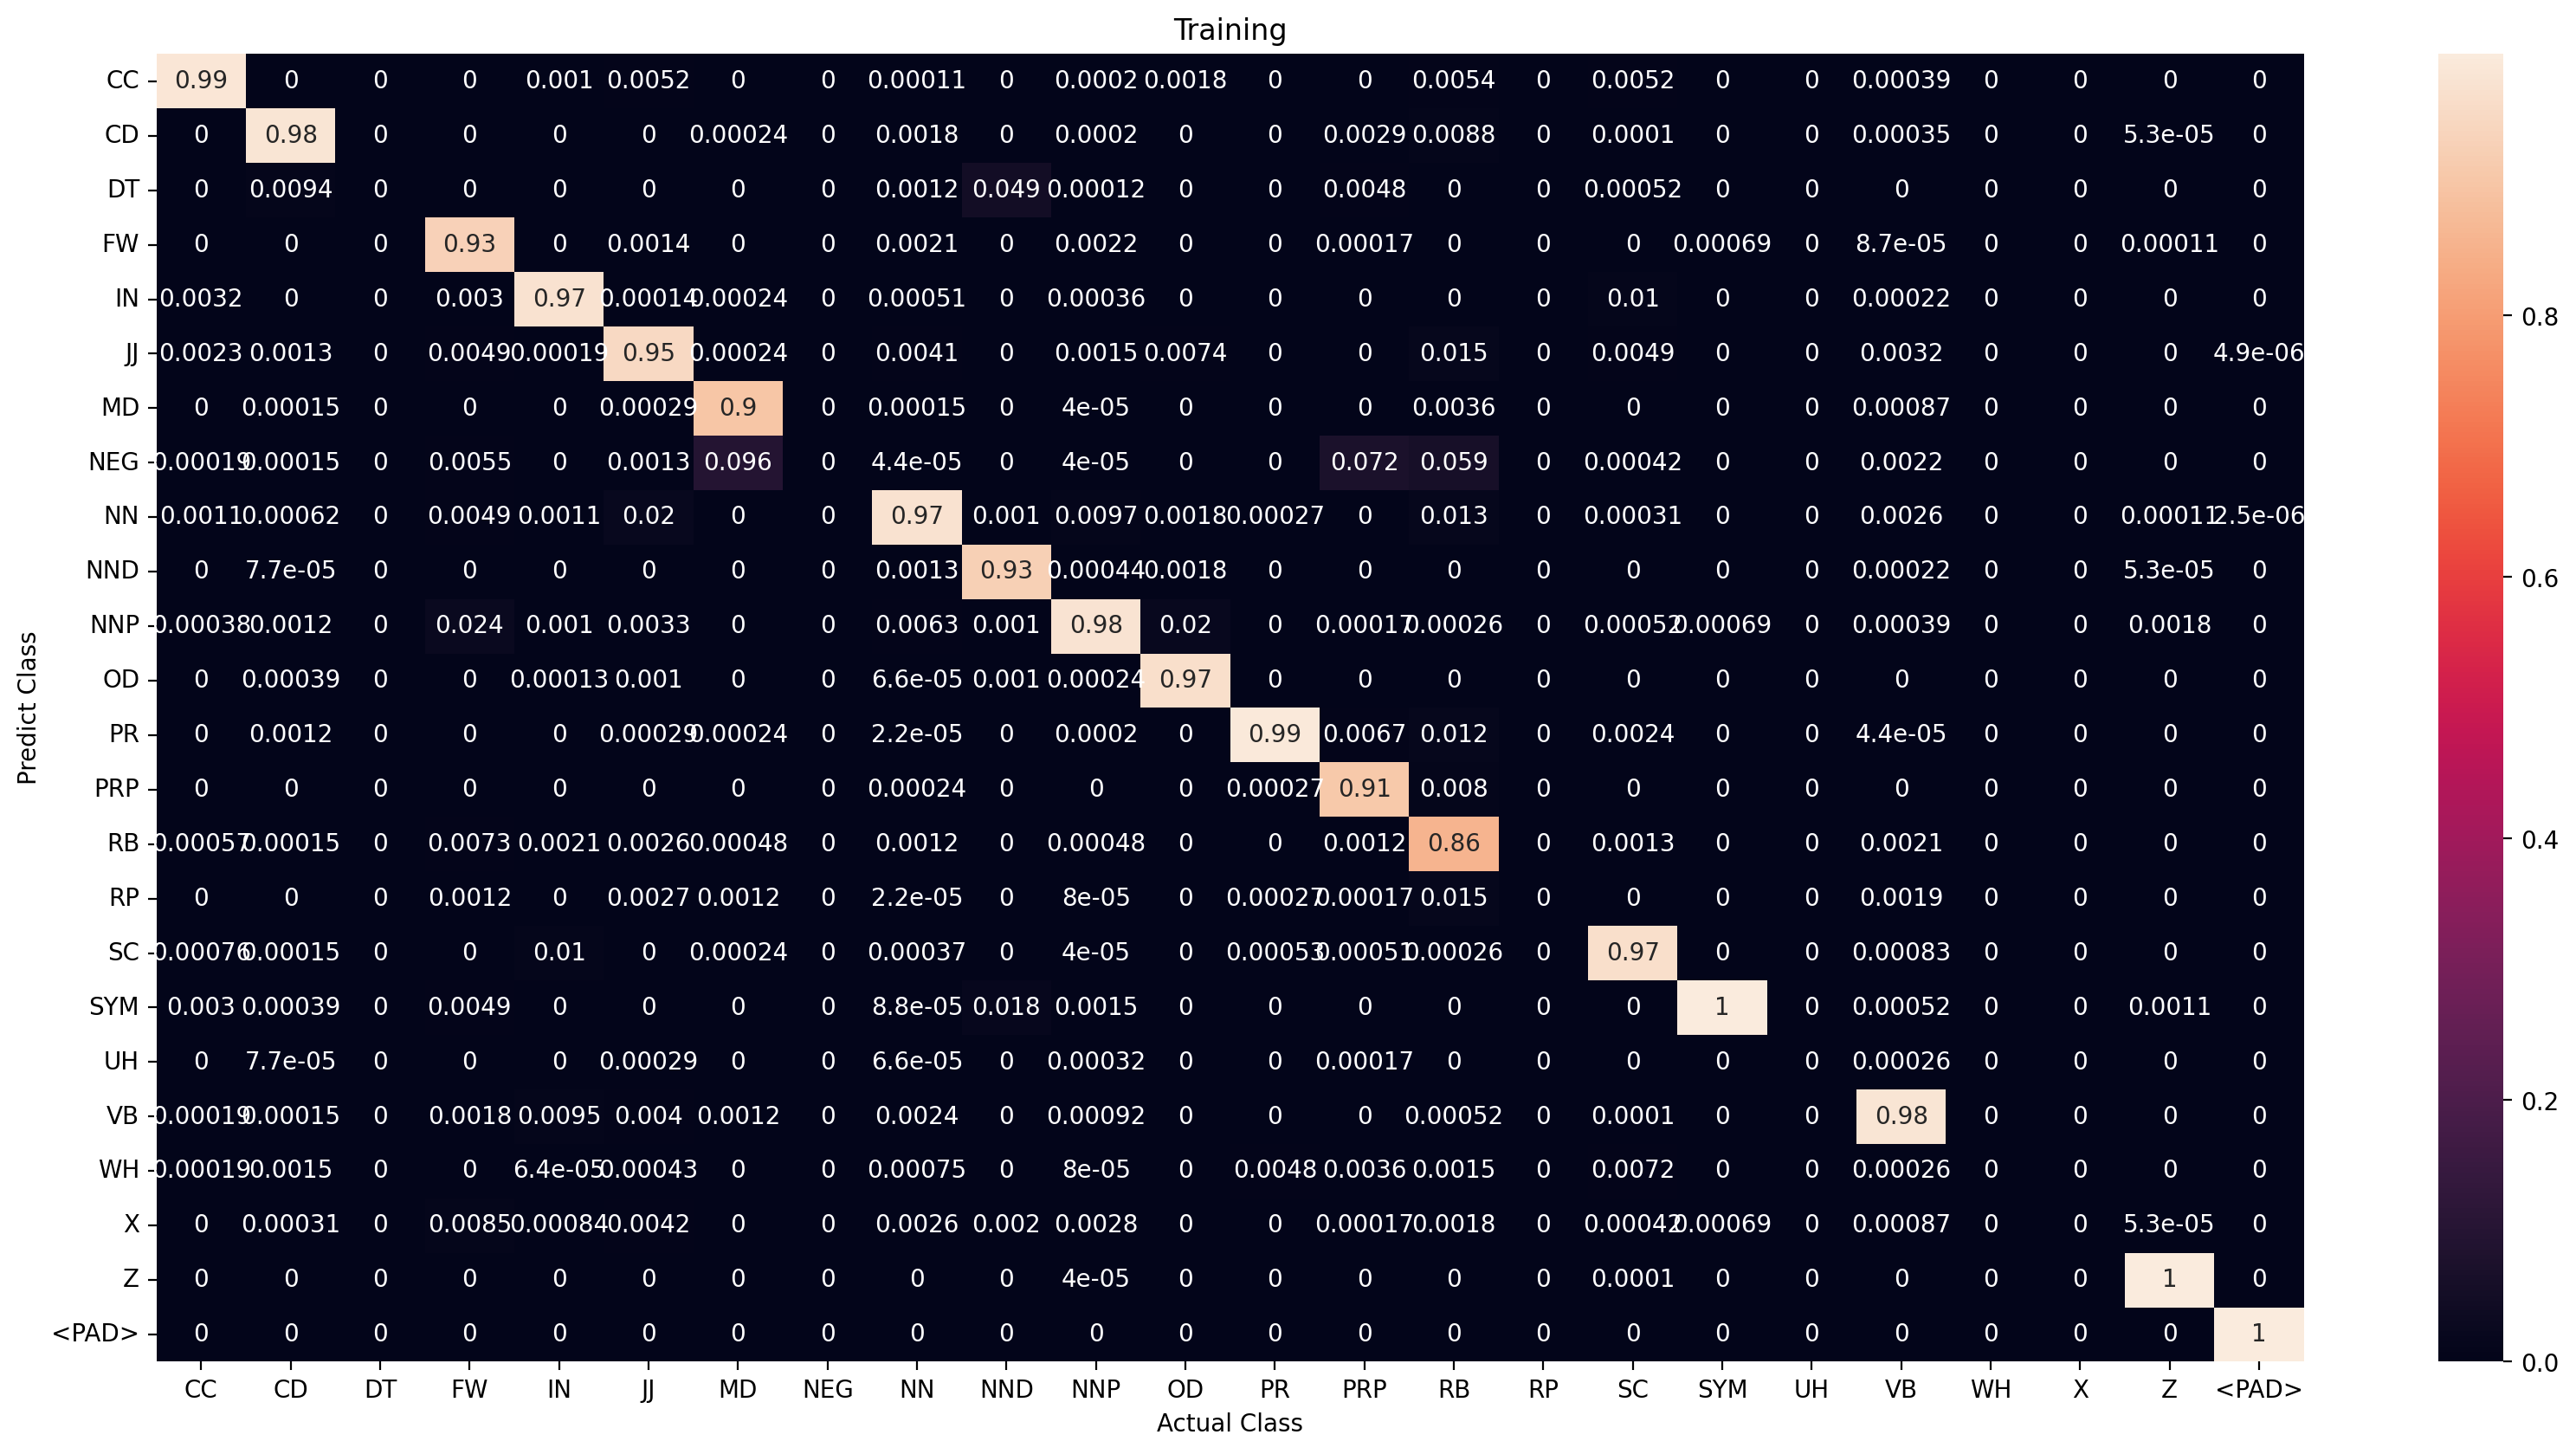

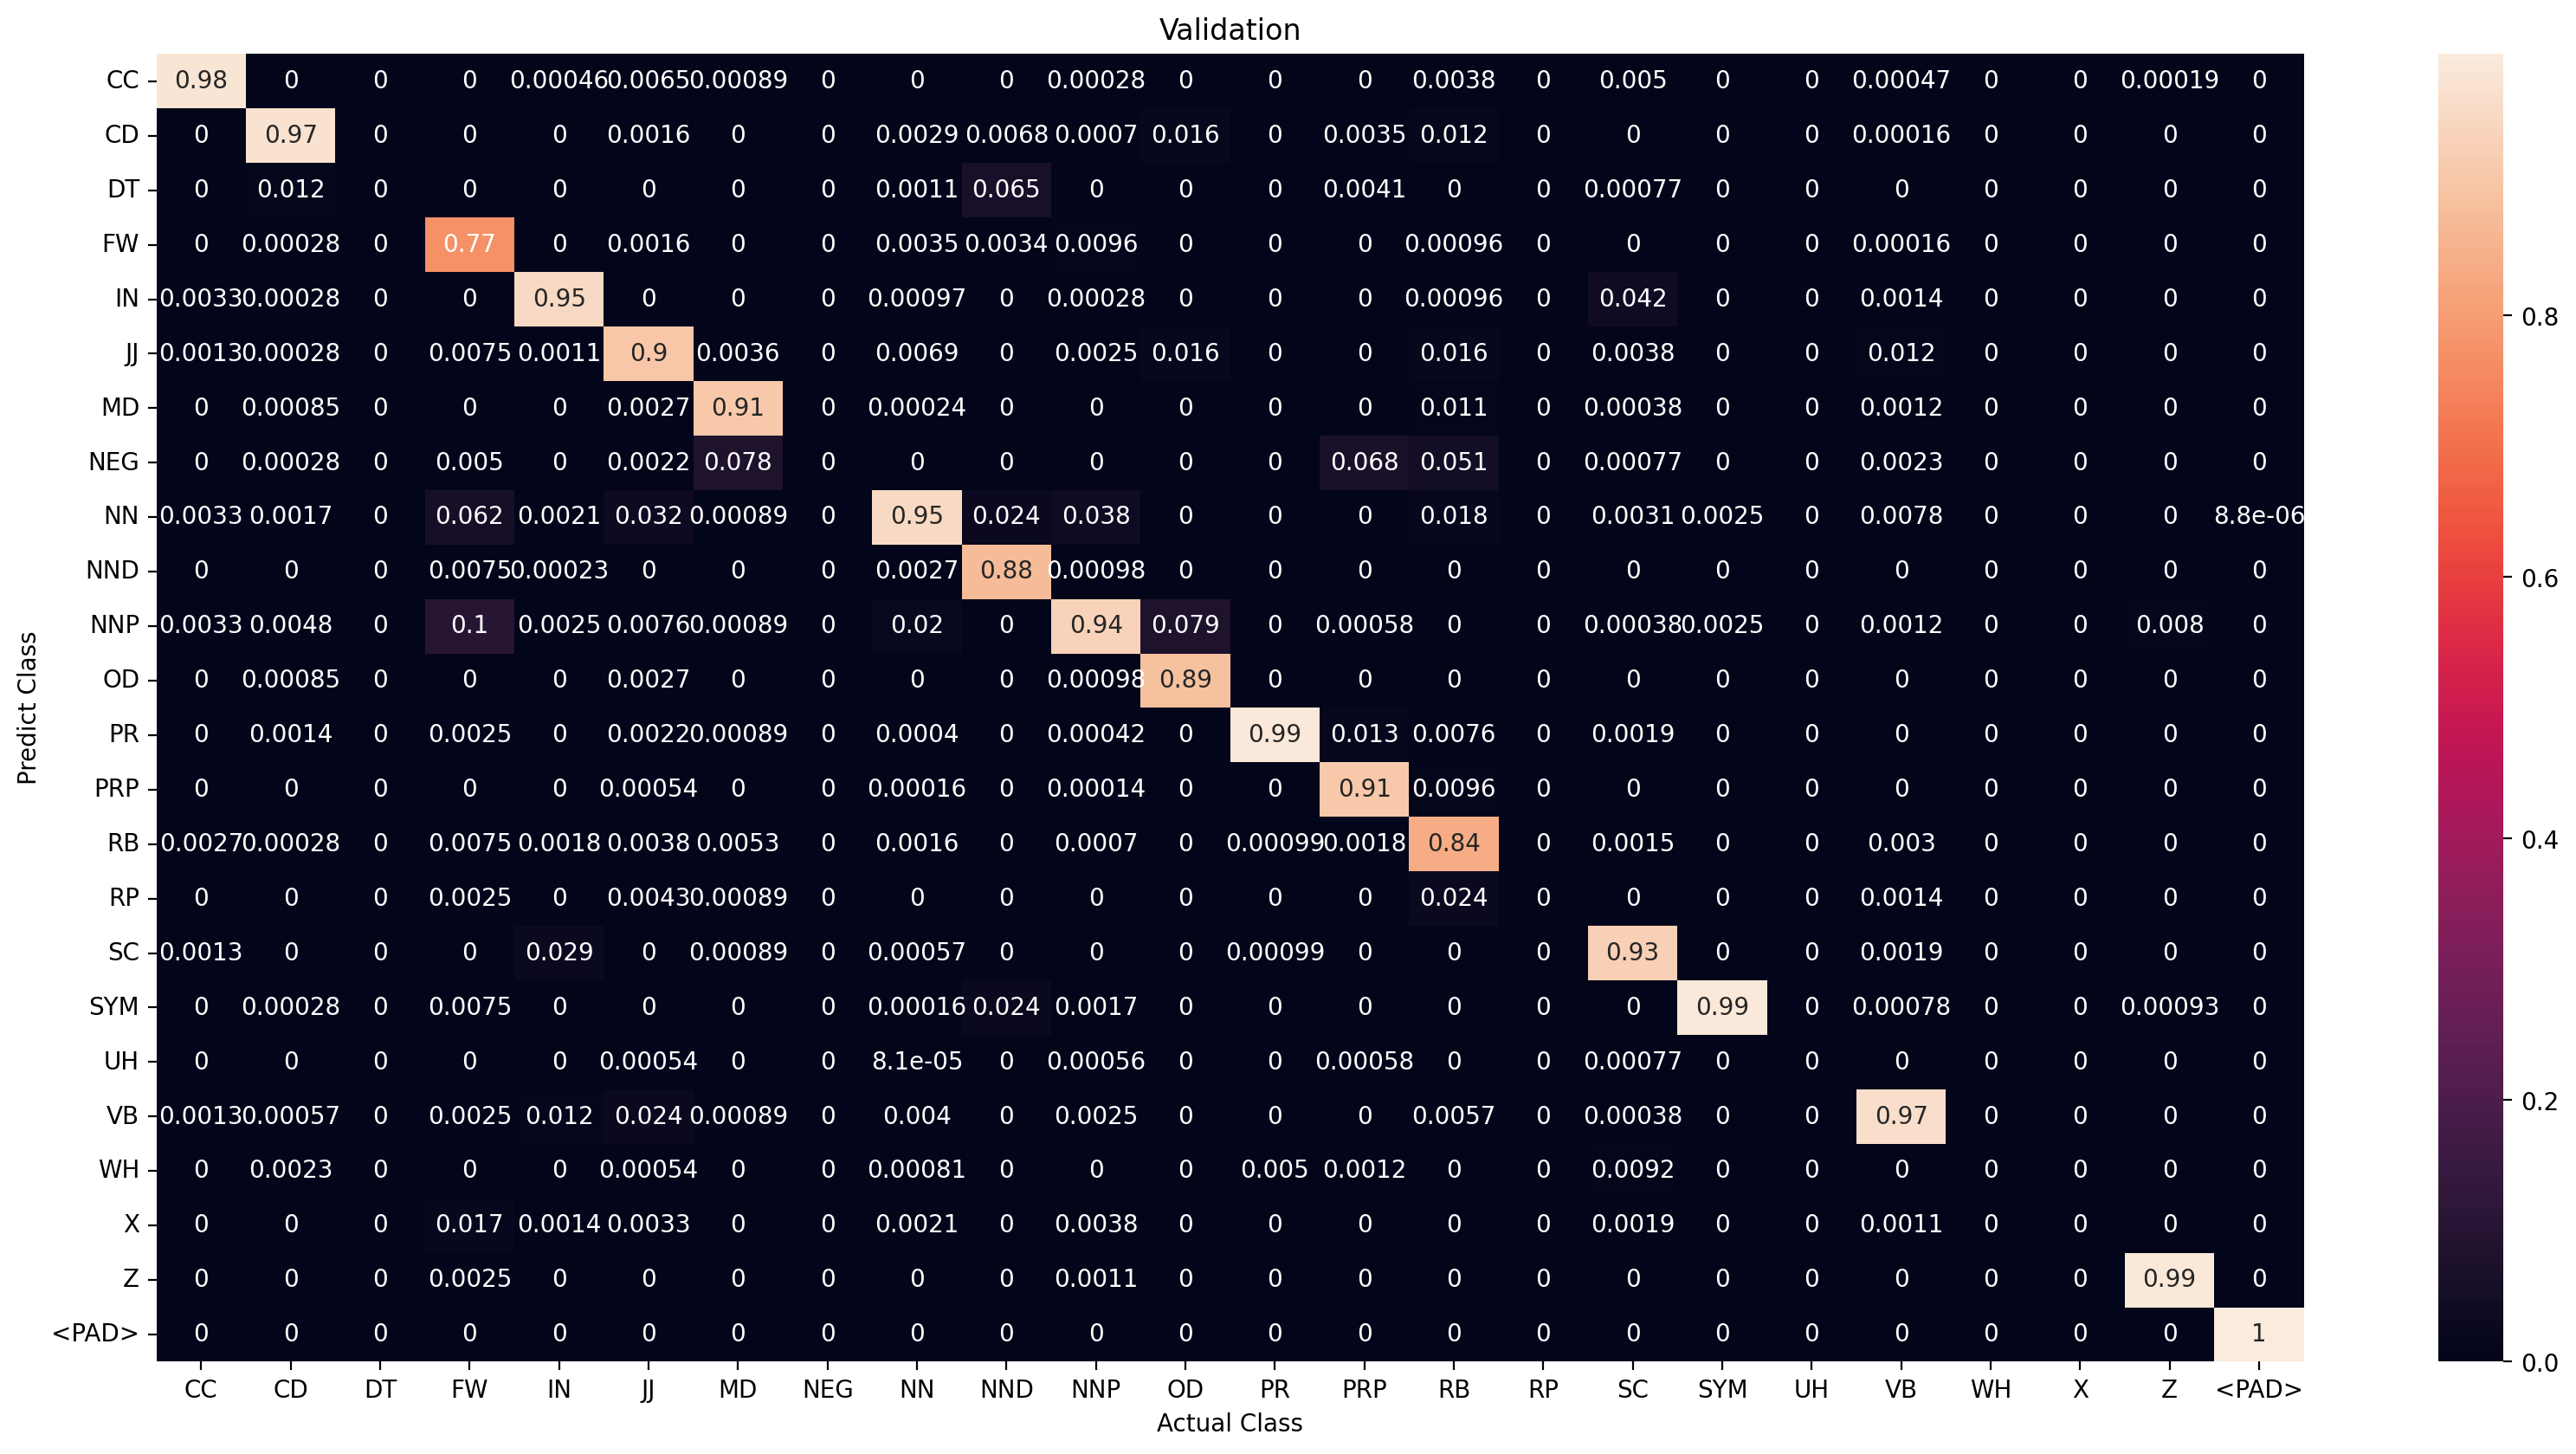

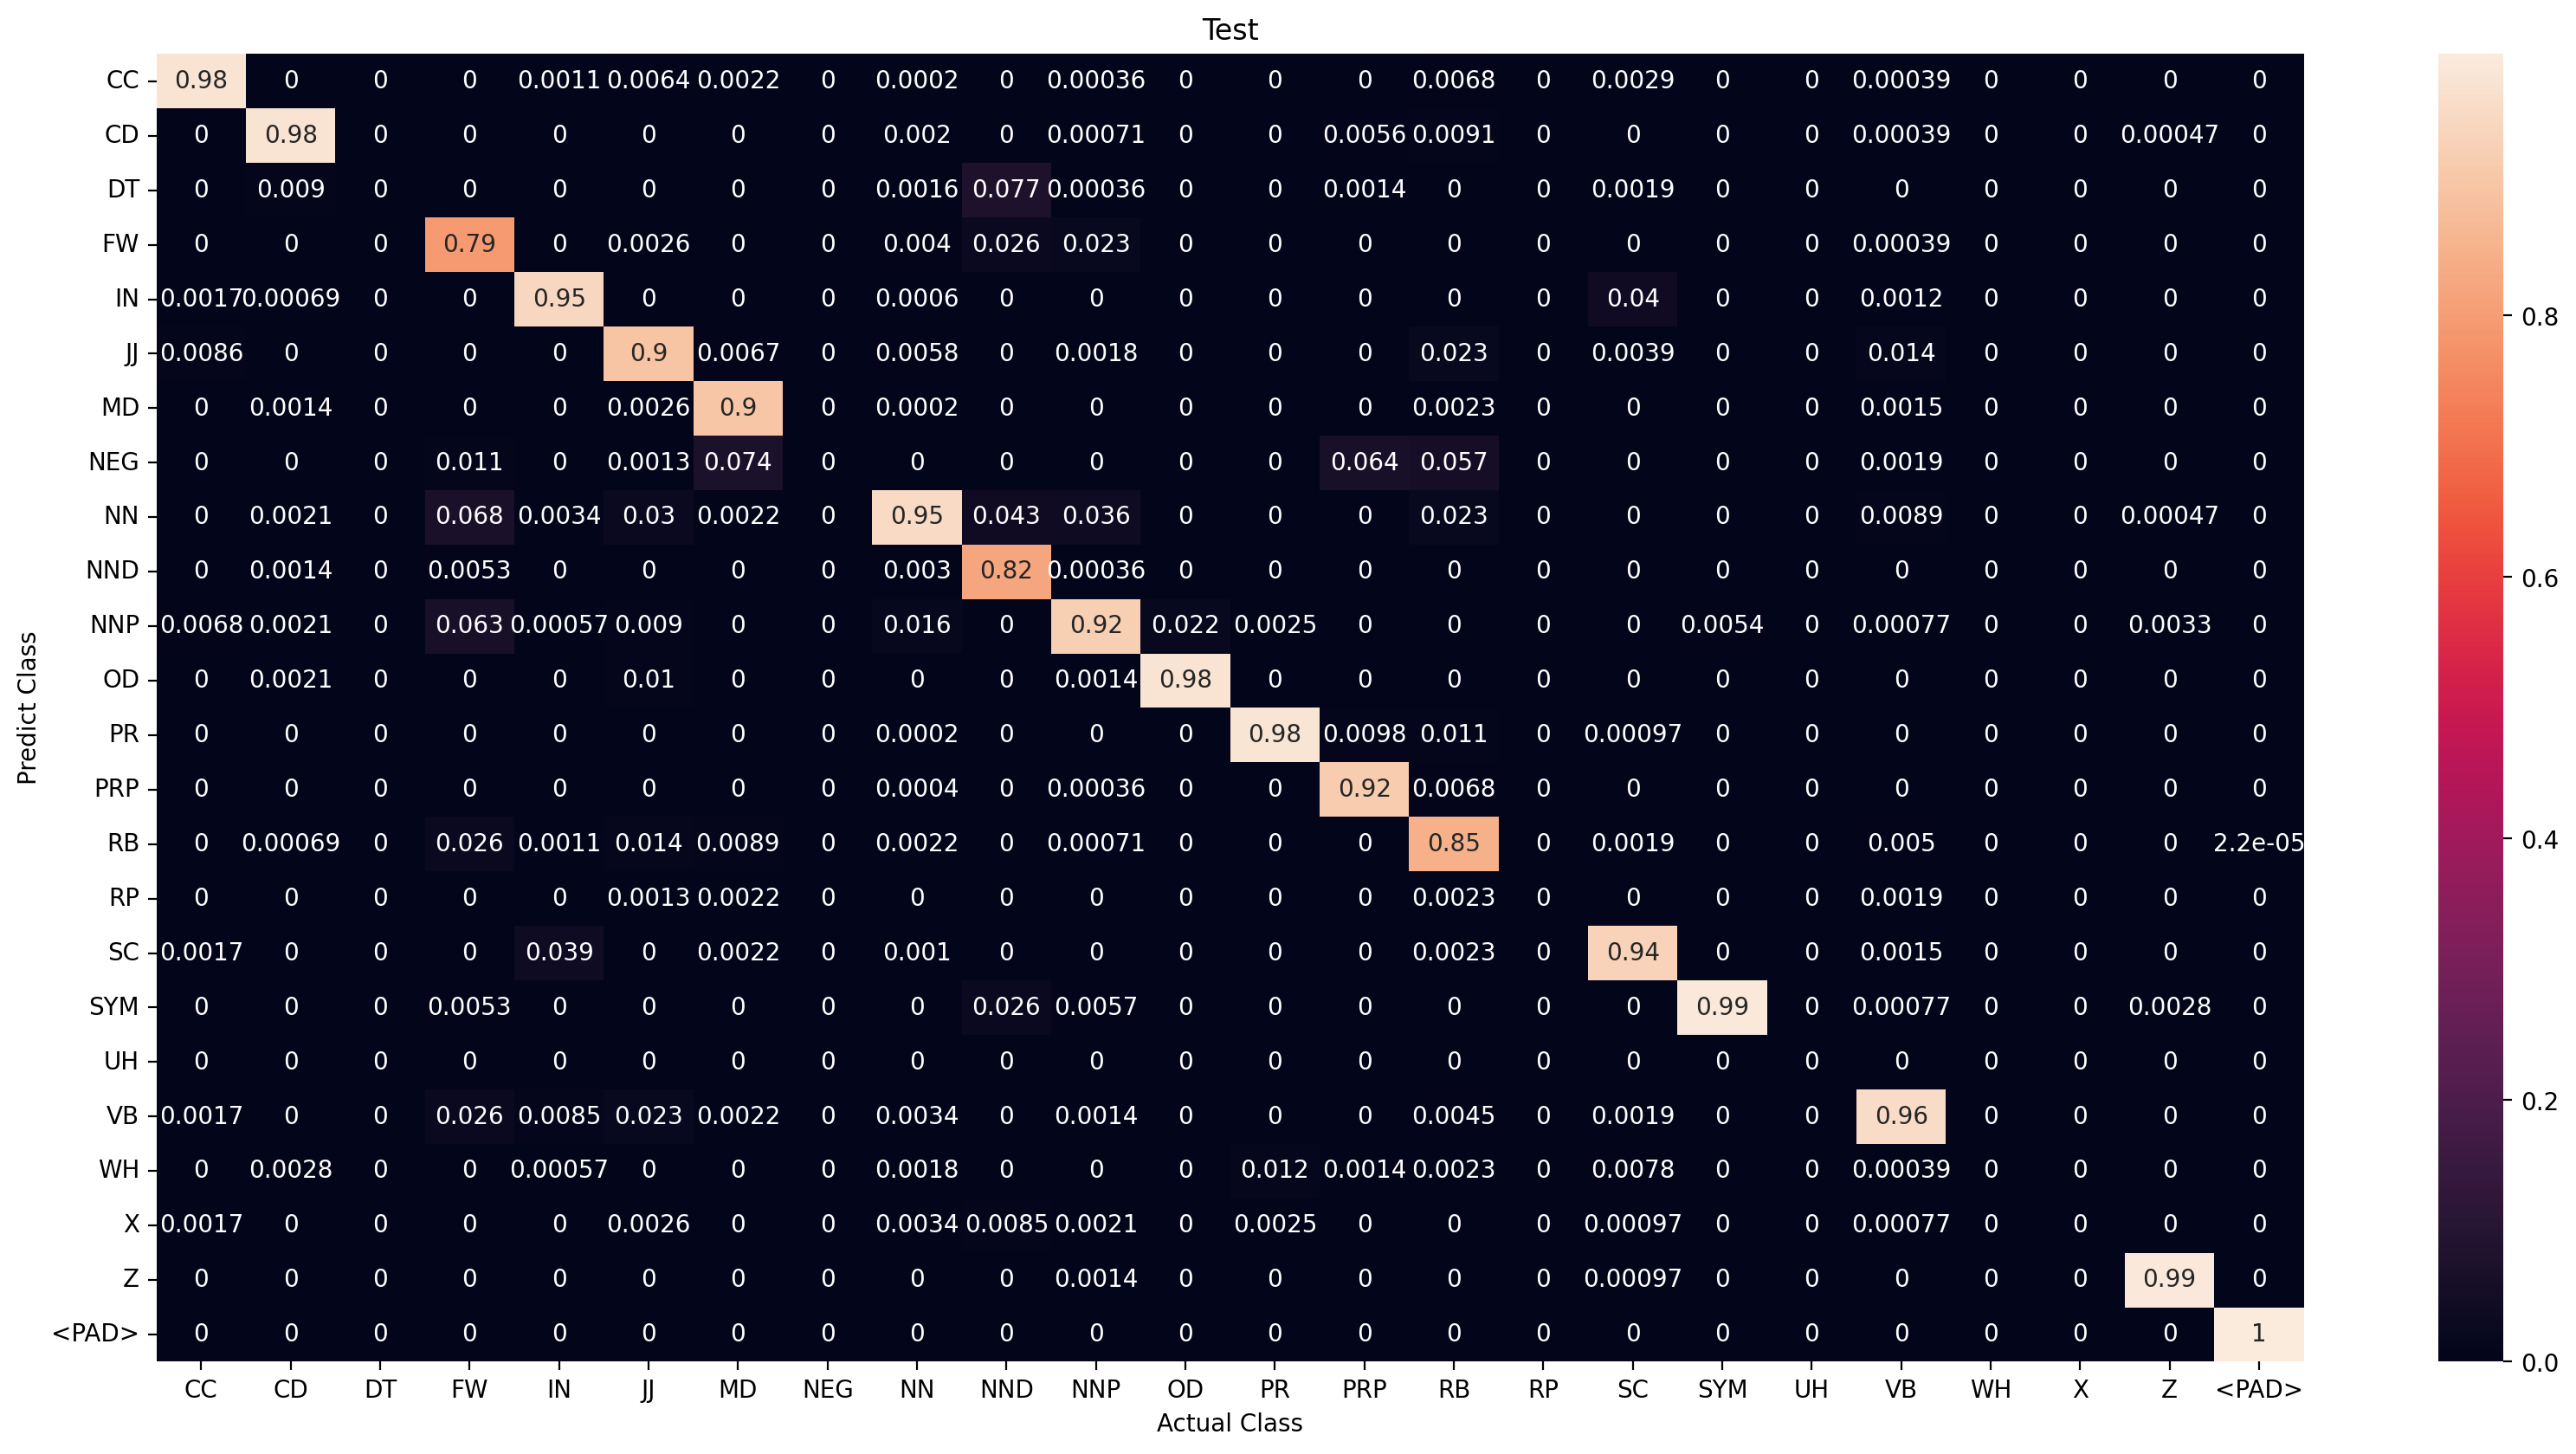

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5336   | CC    : 5193       | CC    : 143      |
| CD    : 12904  | CD    : 12756      | CD    : 148      |
| DT    : 263    | DT    : 0          | DT    : 263      |
| FW    : 1697   | FW    : 1532       | FW    : 165      |
| IN    : 15290  | IN    : 15133      | IN    : 157      |
| JJ    : 7049   | JJ    : 6602       | JJ    : 447      |
| MD    : 3783   | MD    : 3737       | MD    : 46       |
| NEG   : 1126   | NEG   : 0          | NEG   : 1126     |
| NN    : 44769  | NN    : 44233      | NN    : 536      |
| NND   : 998    | NND   : 918        | NND   : 80       |
| NNP   : 24884  | NNP   : 24439      | NNP   : 445      |
| OD    : 550    | OD    : 526        | OD    : 24       |
| PR    : 3878   | PR    : 3742       | PR    : 136      |
| PRP   : 5355   | PRP   : 5312       | PRP   : 43       |
| RB    : 3517   | RB    : 3314       | RB    : 203      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8,  5,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11934
Correct prediction          : 11284
Wrong prediction            : 650
Percentage correct oov pred : 94.55337690631809

Validation
Number OOV token            : 3261
Correct prediction          : 2934
Wrong prediction            : 327
Percentage correct oov pred : 89.97240110395585

Test
Number OOV token            : 1367
Correct prediction          : 1217
Wrong prediction            : 150
Percentage correct oov pred : 89.02706656912947



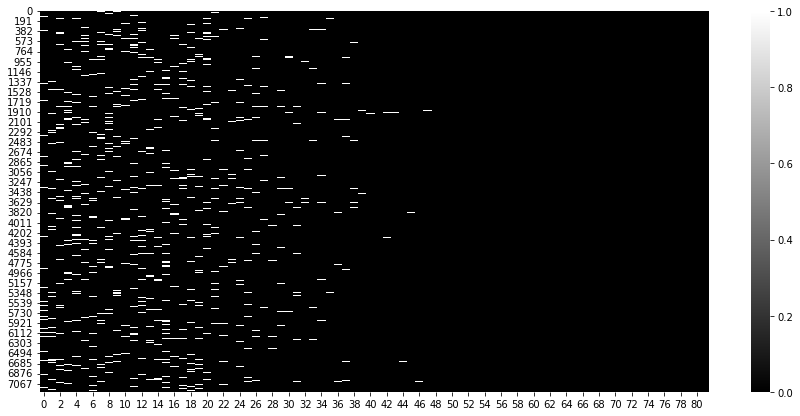

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

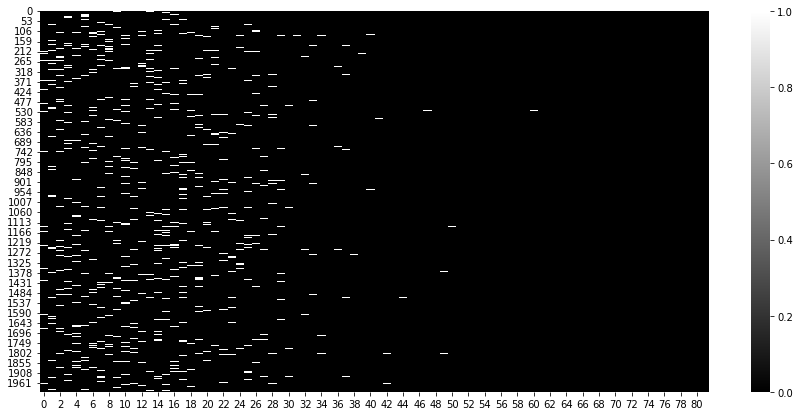

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

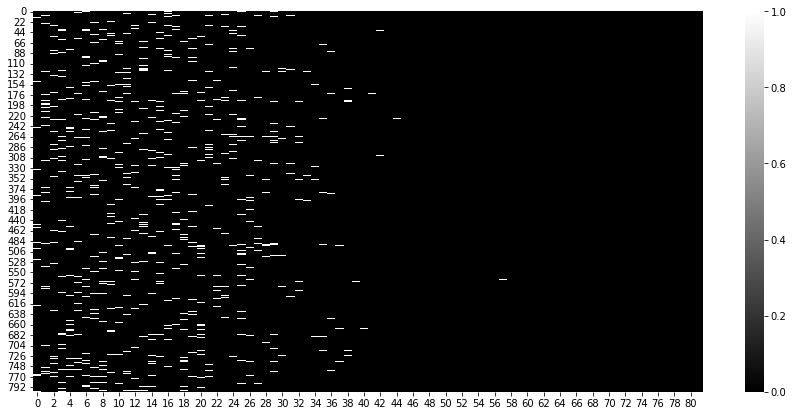

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);